In [1]:
import pandas as pd
import math
import numpy as np
import json

from pathlib import Path
import scipy.stats as st

In [13]:
# Collect predictions

def check_num_epochs(run):
    if Path(run / "val_log.csv").is_file():
        with open(run / 'config.json') as f:
            cfg = json.load(f)

        num_epochs = cfg['num_epochs']
        val_iter = cfg['validate_iter']
        num_epochs = int(num_epochs / val_iter)

        valid_log = pd.read_csv(run / "val_log.csv", header=None, index_col=0)
        if (len(valid_log.index)-1) < num_epochs:
            print("Wrong number of epochs in run: {}".format(run))
    else:
        print("val_log.csv not exists in run: {}".format(run))

def check_only_one_tensorboard(run):
    if len(list(Path(run / "runs").glob('*'))) > 1:
        print("More than 1 tensorboard folder in run: {}".format(run))

def collect_one(model_name, run, csv_file):
    check_num_epochs(run)
    check_only_one_tensorboard(run)
    
    with open(run / 'config.json') as f:
        cfg = json.load(f)

    run_number = cfg['seed']
    regime, inv_temp = float(run.parent.parts[-1].rsplit('-', 1)[1]), float(run.parent.parts[-2].rsplit('-', 1)[1])

    csv_path = run / csv_file
    if not csv_path.exists():
        print(f'Skipping not found: {csv_path}')
        return pd.DataFrame()
    
    data = pd.read_csv(csv_path)
    if data.empty:
        print(f'Pred file is empty: {csv_path}')

    data['model'] = model_name
    data['run_number'] = int(run_number)
    data['inv_temp'] = int(inv_temp)
    data['regime'] = int(regime)
    
    return data

def collect_all(model_name, root, csv_file, regimes=['1', '2', '5', '10', '20','100'], ignore_outliers=True):
    root = Path(root)

    metrics = []
    for inv_temp in list(root.glob("inv_temp-*")):
        for regime in list(inv_temp.glob("regime-*")):
            if regime.name.rsplit("-", 1)[1] in regimes:
                for run in list(regime.glob("run-*")):
                    if not ignore_outliers and 'outlier' in run.as_posix():
                        continue
                    else:
                        metrics.append(collect_one(model_name, run, csv_file))
        
    metrics = pd.concat(metrics, ignore_index=True)
    
    return metrics

In [3]:
# Compute metrics for each detected run

def compute_metrics(data, grouping, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance']):
    metrics_dict_names = {
        'Dice': 'dice',
        'Jaccard': 'jaccard',
        'Hausdorff Distance': '95hd',
        'Average Surface Distance': 'asd'
    }

    columns = ['Model', '# Run', 'Inv Temp', 'Regime']
    columns.extend(metric_names)
    metrics = []
    
    data = data.copy().reset_index()
    grouped = data.groupby(grouping)
    
    for model_group, predictions in grouped:
        model_name, run_number, inv_temp, regime = model_group[0], int(model_group[1]), int(model_group[2]), int(model_group[3])
        
        metric_values = []
        for metric_name in metric_names:
            values = predictions['segm/{}'.format(metrics_dict_names[metric_name])].values
            mean_value = np.nanmean(values)
            if metric_name == 'Dice' or metric_name == 'Jaccard':
                metric_values.append((math.ceil(mean_value*10000)/10000)*100)
            else:
                if not np.isnan(mean_value):
                    metric_values.append(math.ceil(mean_value*100)/100)
                else:
                    metric_values.append(mean_value)
        
        metrics.append([model_name, run_number, inv_temp, regime, *metric_values])
        
    metrics_df = pd.DataFrame(metrics, columns=columns)
    
    return metrics_df

def summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90, return_ranges=False):

    def compute_ci(values, return_ranges=False):
        ci = st.t.interval(confidence_level, len(values)-1, loc=np.mean(values), scale=np.std(values)/(len(values)**0.5))

        if return_ranges:
            return ci
        else:
            return (ci[1]-ci[0]) / 2

    #mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ('STD', np.std), ("CI {}%".format(confidence_level), compute_ci)])
    mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', 'mean'), ("CI {}%".format(confidence_level), compute_ci)]) 

    return mean_metrics

<h1>PH2 Dataset</h1>

<h2>Evaluation - Data regime variations</h2>

In [ ]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['1', '2', '5', '10', '20']

runs = {
    #'UNet': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('kaiming_unet')),
    'EM': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('em_unet')),
    'UAMT': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('uamt_unet')),
    'CPS': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('cps_unet')),
    'URPC': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('urpc_unet')),
    'CCT': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('cct_unet')),
    'VAE': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('unet_vae')),
    'SuperPix': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('unet_superpix')),
}

In [290]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [291]:
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,URPC,2,1,20,91.91,85.02,6.32,2.46
1,URPC,4,1,20,91.55,84.41,6.38,2.51


Dice           Jaccard           Hausdorff Distance  \
                        Mean   CI 0.9%    Mean   CI 0.9%               Mean   
Model Inv Temp Regime                                                         
URPC  1        20      91.73  0.803609  84.715  1.361671               6.35   

                                Average Surface Distance            
                        CI 0.9%                     Mean   CI 0.9%  
Model Inv Temp Regime                                               
URPC  1        20      0.133935                    2.485  0.111612

<h2>Evaluation - Unsupervised Pretraining</h2>

In [372]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['100']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/PH2/hebbian_unsup/').glob('unet_swta_t')),
    'H-UNet-URPC-SWTA-T': list(Path(EXP_ROOT + '/PH2/hebbian_unsup/').glob('unet_urpc_swta_t')),
    'H-UNet-CCT-SWTA-T': list(Path(EXP_ROOT + '/PH2/hebbian_unsup/').glob('unet_cct_swta_t')),
    'VAE-UNet': list(Path(EXP_ROOT + '/PH2/vae_unsup/').glob('unet_vae')),
    'Superpix-UNet': list(Path(EXP_ROOT + '/PH2/superpix_unsup/').glob('unet_superpix')),
}

In [373]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [374]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-CCT-SWTA-T,0,1,100,32.18,19.18,51.19,13.26
1,H-UNet-CCT-SWTA-T,0,5,100,29.59,17.37,51.49,13.52
2,H-UNet-CCT-SWTA-T,0,10,100,27.59,16.00,51.52,13.75
3,H-UNet-CCT-SWTA-T,0,20,100,30.90,18.28,51.17,13.20
4,H-UNet-CCT-SWTA-T,0,50,100,32.22,19.21,51.13,13.06
5,H-UNet-CCT-SWTA-T,0,75,100,32.44,19.36,51.12,13.05
6,H-UNet-CCT-SWTA-T,0,100,100,32.54,19.43,51.12,13.04
7,H-UNet-SWTA-T,0,1,100,30.01,17.65,51.33,13.60
8,H-UNet-SWTA-T,0,5,100,26.94,15.57,51.95,14.06
9,H-UNet-SWTA-T,0,10,100,25.57,14.66,51.84,14.04


/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-CCT-SWTA-T  1        100     32.18     NaN   19.18     NaN   
                   5        100     29.59     NaN   17.37     NaN   
                   10       100     27.59     NaN   16.00     NaN   
                   20       100     30.90     NaN   18.28     NaN   
                   50       100     32.22     NaN   19.21     NaN   
                   75       100     32.44     NaN   19.36     NaN   
                   100      100     32.54     NaN   19.43     NaN   
H-UNet-SWTA-T      1        100     30.01     NaN   17.65     NaN   
                   5        100     26.94     NaN   15.57     NaN   
                   10       100     25.57     NaN   14.66     NaN   
                   20       100     31.88     NaN   18.96     NaN   
                   50       100     33.45     NaN   20.09     NaN   
                   75       100     33.85     NaN   20.37     NaN   
                   100      100     34.02     NaN   20.50     NaN   
                   200      100     32.35     NaN   19.30     NaN   
H-UNet-URPC-SWTA-T 1        100     35.48     NaN   21.57     NaN   
                   5        100     35.88     NaN   21.87     NaN   
                   10       100     35.21     NaN   21.37     NaN   
                   20       100     35.29     NaN   21.43     NaN   
                   50       100     35.08     NaN   21.27     NaN   
                   75       100     35.07     NaN   21.27     NaN   
                   100      100     35.06     NaN   21.26     NaN   
                   200      100     34.97     NaN   21.19     NaN   
Superpix-UNet      1        100     50.26     NaN   33.57     NaN   
VAE-UNet           1        100     75.57     NaN   60.74     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-CCT-SWTA-T  1        100                 51.19     NaN   
                   5        100                 51.49     NaN   
                   10       100                 51.52     NaN   
                   20       100                 51.17     NaN   
                   50       100                 51.13     NaN   
                   75       100                 51.12     NaN   
                   100      100                 51.12     NaN   
H-UNet-SWTA-T      1        100                 51.33     NaN   
                   5        100                 51.95     NaN   
                   10       100                 51.84     NaN   
                   20       100                 51.83     NaN   
                   50       100                 51.70     NaN   
                   75       100                 51.65     NaN   
                   100      100                 51.62     NaN   
                   200      100                 51.15     NaN   
H-UNet-URPC-SWTA-T 1        100                 46.81     NaN   
                   5        100                 47.81     NaN   
                   10       100                 47.50     NaN   
                   20       100                 47.38     NaN   
                   50       100                 47.40     NaN   
                   75       100                 47.39     NaN   
                   100      100                 47.39     NaN   
                   200      100                 47.67     NaN   
Superpix-UNet      1        100                 48.07     NaN   
VAE-UNet           1        100                 38.65     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-CCT-SWTA-T  1        100                       13.26     NaN  
   

<h2>Evaluation - Hebbian Models Data Regime Variations</h2>

In [4]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/"

REGIMES = ['1', '2', '5', '10', '20']
REGIMES = ['20']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_unet_swta_t')),
    #'H-EM-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_em_unet_swta_t')),
    #'H-UAMT-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_uamt_unet_swta_t')),
    #'H-CPS-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_cps_unet_swta_t')),
    #'H-URPC-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_urpc_unet_swta_t')),
    #'H-CCT-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_cct_unet_swta_t')),
}

In [5]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [6]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard','Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-SWTA-T,0,1,20,86.76,76.62,11.88,4.30
1,H-UNet-SWTA-T,0,5,20,83.83,72.15,13.15,5.02
2,H-UNet-SWTA-T,0,10,20,89.61,81.18,11.84,3.52
3,H-UNet-SWTA-T,0,50,20,89.53,81.04,9.53,3.32
4,H-UNet-SWTA-T,0,75,20,89.92,81.69,8.39,3.24
...,...,...,...,...,...,...,...,...
57,H-UNet-SWTA-T,9,5,20,82.40,70.07,13.52,5.78
58,H-UNet-SWTA-T,9,10,20,85.84,75.20,11.97,4.45
59,H-UNet-SWTA-T,9,50,20,87.00,76.99,11.64,4.42
60,H-UNet-SWTA-T,9,75,20,85.63,74.88,12.43,4.42


Dice           Jaccard            \
                                 Mean   CI 0.9%    Mean   CI 0.9%   
Model         Inv Temp Regime                                       
H-UNet-SWTA-T 1        20      86.575  1.519774  76.424  2.382569   
              5        20      86.819  1.162802  76.760  1.781337   
              10       20      89.006  0.981509  80.230  1.588906   
              20       20      91.495  0.825932  84.320  1.383994   
              50       20      88.848  0.722962  79.953  1.168192   
              75       20      89.056  1.060887  80.317  1.722488   
              100      20      89.152  0.860626  80.455  1.410828   

                              Hausdorff Distance            \
                                            Mean   CI 0.9%   
Model         Inv Temp Regime                                
H-UNet-SWTA-T 1        20                 13.053  1.436363   
              5        20                 12.715  1.657179   
              10       20                 11.711  1.030560   
              20       20                  9.310  8.125384   
              50       20                 12.282  1.033387   
              75       20                 11.498  1.294974   
              100      20                 11.974  1.410004   

                              Average Surface Distance            
                                                  Mean   CI 0.9%  
Model         Inv Temp Regime                                     
H-UNet-SWTA-T 1        20                        4.575  0.484478  
              5        20                        4.399  0.409515  
              10       20                        3.747  0.274906  
              20       20                        3.130  1.875089  
              50       20                        4.203  0.294317  
              75       20                        3.877  0.310127  
              100      20                        3.897  0.327856

<h1>GlaS Dataset</h1>

<h2>Evaluation - Data regime variations</h2>

In [ ]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['1', '2', '5', '10', '20']

runs = {
    #'UNet': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('kaiming_unet')),
    'EM': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('em_unet')),
    'UAMT': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('uamt_unet')),
    'CPS': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('cps_unet')),
    'URPC': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('urpc_unet')),
    'CCT': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('cct_unet')),
    'VAE': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('unet_vae')),
    'SuperPix': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('unet_superpix')),
}

In [85]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [86]:
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,CCT,0,1,20,82.44,70.12,16.51,3.27
1,CCT,2,1,20,84.94,73.82,13.76,2.96
2,CCT,4,1,20,84.96,73.85,13.52,2.84
3,CCT,5,1,20,85.33,74.40,13.42,2.76
4,CCT,6,1,20,85.01,73.93,14.03,3.02
5,CCT,7,1,20,84.48,73.13,13.40,2.81
6,CCT,9,1,20,82.44,70.13,15.19,3.22


Dice              Jaccard            \
                            Mean   CI 0.9%       Mean   CI 0.9%   
Model Inv Temp Regime                                             
CCT   1        20      84.228571  0.847744  72.768571  1.253593   

                      Hausdorff Distance           Average Surface Distance  \
                                    Mean   CI 0.9%                     Mean   
Model Inv Temp Regime                                                         
CCT   1        20              14.261429  0.796036                 2.982857   

                                 
                        CI 0.9%  
Model Inv Temp Regime            
CCT   1        20      0.136148

<h2>Evaluation - Unsupervised Pretraining</h2>

In [375]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['100']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/GlaS/hebbian_unsup/').glob('unet_swta_t')),
    'H-UNet-URPC-SWTA-T': list(Path(EXP_ROOT + '/GlaS/hebbian_unsup/').glob('unet_urpc_swta_t')),
    'H-UNet-CCT-SWTA-T': list(Path(EXP_ROOT + '/GlaS/hebbian_unsup/').glob('unet_cct_swta_t')),
    'VAE-UNet': list(Path(EXP_ROOT + '/GlaS/vae_unsup/').glob('unet_vae')),
    'Superpix-UNet': list(Path(EXP_ROOT + '/GlaS/superpix_unsup/').glob('unet_superpix')),
}

In [376]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [377]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

/tmp/ipykernel_1197372/27984749.py:24: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(values)


,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-CCT-SWTA-T,0,1,100,38.71,24.00,NaN,NaN
1,H-UNet-CCT-SWTA-T,0,5,100,39.73,24.79,NaN,NaN
2,H-UNet-CCT-SWTA-T,0,10,100,40.49,25.38,NaN,NaN
3,H-UNet-CCT-SWTA-T,0,20,100,41.47,26.16,NaN,NaN
4,H-UNet-CCT-SWTA-T,0,50,100,41.68,26.33,NaN,NaN
5,H-UNet-CCT-SWTA-T,0,75,100,41.73,26.37,NaN,NaN
6,H-UNet-CCT-SWTA-T,0,100,100,41.75,26.38,NaN,NaN
7,H-UNet-SWTA-T,0,1,100,37.59,23.14,20.22,4.23
8,H-UNet-SWTA-T,0,5,100,38.85,24.11,20.49,4.26
9,H-UNet-SWTA-T,0,10,100,40.69,25.55,20.63,4.27


/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-CCT-SWTA-T  1        100     38.71     NaN   24.00     NaN   
                   5        100     39.73     NaN   24.79     NaN   
                   10       100     40.49     NaN   25.38     NaN   
                   20       100     41.47     NaN   26.16     NaN   
                   50       100     41.68     NaN   26.33     NaN   
                   75       100     41.73     NaN   26.37     NaN   
                   100      100     41.75     NaN   26.38     NaN   
H-UNet-SWTA-T      1        100     37.59     NaN   23.14     NaN   
                   5        100     38.85     NaN   24.11     NaN   
                   10       100     40.69     NaN   25.55     NaN   
                   20       100     41.58     NaN   26.25     NaN   
                   50       100     41.81     NaN   26.43     NaN   
                   75       100     41.85     NaN   26.46     NaN   
                   100      100     41.87     NaN   26.48     NaN   
H-UNet-URPC-SWTA-T 1        100     61.08     NaN   43.97     NaN   
                   5        100     61.66     NaN   44.57     NaN   
                   10       100     61.22     NaN   44.12     NaN   
                   20       100     60.84     NaN   43.72     NaN   
                   50       100     60.74     NaN   43.61     NaN   
                   75       100     60.73     NaN   43.60     NaN   
                   100      100     60.72     NaN   43.60     NaN   
Superpix-UNet      1        100     60.22     NaN   43.08     NaN   
VAE-UNet           1        100     57.48     NaN   40.33     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-CCT-SWTA-T  1        100                   NaN     NaN   
                   5        100                   NaN     NaN   
                   10       100                   NaN     NaN   
                   20       100                   NaN     NaN   
                   50       100                   NaN     NaN   
                   75       100                   NaN     NaN   
                   100      100                   NaN     NaN   
H-UNet-SWTA-T      1        100                 20.22     NaN   
                   5        100                 20.49     NaN   
                   10       100                 20.63     NaN   
                   20       100                 20.88     NaN   
                   50       100                 20.94     NaN   
                   75       100                 20.95     NaN   
                   100      100                 20.96     NaN   
H-UNet-URPC-SWTA-T 1        100                   NaN     NaN   
                   5        100                   NaN     NaN   
                   10       100                   NaN     NaN   
                   20       100                   NaN     NaN   
                   50       100                   NaN     NaN   
                   75       100                   NaN     NaN   
                   100      100                   NaN     NaN   
Superpix-UNet      1        100                 27.82     NaN   
VAE-UNet           1        100                 18.34     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-CCT-SWTA-T  1        100                         NaN     NaN  
                   5        100                         NaN     NaN  
                   10       100                         NaN     NaN  
                   20       100                         NaN     NaN  
                   50       100                         NaN  

<h2>Evaluation - Hebbian Models Data Regime Variations</h2>

In [173]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/"

REGIMES = ['1', '2', '5', '10', '20']
REGIMES = ['20']

runs = {
    #'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_unet_swta_t')),
    #'H-EM-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_em_unet_swta_t')),
    'H-UAMT-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_uamt_unet_swta_t')),
    #'H-CPS-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_cps_unet_swta_t')),
    #'H-URPC-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_urpc_unet_swta_t')),
    #'H-CCT-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_cct_unet_swta_t')),
}

In [180]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [181]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard'])

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard
0,H-UAMT-SWTA-T,1,50,20,81.71,69.08
1,H-UAMT-SWTA-T,2,50,20,82.61,70.37
2,H-UAMT-SWTA-T,3,50,20,83.29,71.36
3,H-UAMT-SWTA-T,4,50,20,84.33,72.90
4,H-UAMT-SWTA-T,5,50,20,84.75,73.53
5,H-UAMT-SWTA-T,8,50,20,85.88,75.25


Dice              Jaccard          
                                    Mean   CI 0.9%       Mean   CI 0.9%
Model         Inv Temp Regime                                          
H-UAMT-SWTA-T 50       20      83.761667  1.141134  72.081667  1.688126

<h1>HMEPS Dataset</h1>

<h2>Evaluation - Data regime variations</h2>

In [ ]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['1', '2', '5', '10', '20']

runs = {
    #'UNet': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('kaiming_unet')),
    'EM': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('em_unet')),
    'UAMT': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('uamt_unet')),
    'CPS': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('cps_unet')),
    'URPC': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('urpc_unet')),
    'CCT': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('cct_unet')),
    'VAE': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('unet_vae')),
    'SuperPix': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('unet_superpix')),
}

In [245]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

More than 1 tensorboard folder in run: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/HMEPS/semi_sup/unet_superpix/inv_temp-1/regime-20/run-0
More than 1 tensorboard folder in run: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/HMEPS/semi_sup/unet_superpix/inv_temp-1/regime-20/run-1
More than 1 tensorboard folder in run: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/HMEPS/semi_sup/unet_superpix/inv_temp-1/regime-20/run-2
More than 1 tensorboard folder in run: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/HMEPS/semi_sup/unet_superpix/inv_temp-1/regime-20/run-5


In [246]:
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,SuperPix,0,1,20,93.01,86.94,1.65,0.65
1,SuperPix,1,1,20,93.39,87.59,1.91,0.59
2,SuperPix,2,1,20,93.39,87.60,2.01,0.62
3,SuperPix,5,1,20,92.95,86.82,1.49,0.56


Dice            Jaccard            \
                            Mean   CI 0.9%     Mean   CI 0.9%   
Model    Inv Temp Regime                                        
SuperPix 1        20      93.185  0.242508  87.2375  0.423636   

                         Hausdorff Distance            \
                                       Mean   CI 0.9%   
Model    Inv Temp Regime                                
SuperPix 1        20                  1.765  0.242508   

                         Average Surface Distance            
                                             Mean   CI 0.9%  
Model    Inv Temp Regime                                     
SuperPix 1        20                        0.605  0.039467

<h2>Evaluation - Unsupervised Pretraining</h2>

In [387]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['100']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/hebbian_unsup/').glob('unet_swta_t')),
    'H-UNet-URPC-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/hebbian_unsup/').glob('unet_urpc_swta_t')),
    'H-UNet-CCT-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/hebbian_unsup/').glob('unet_cct_swta_t')),
    'VAE-UNet': list(Path(EXP_ROOT + '/HMEPS/vae_unsup/').glob('unet_vae')),
    'Superpix-UNet': list(Path(EXP_ROOT + '/HMEPS/superpix_unsup/').glob('unet_superpix')),
}

In [388]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [389]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-CCT-SWTA-T,0,1,100,2.08,1.05,89.42,23.74
1,H-UNet-CCT-SWTA-T,0,5,100,21.62,12.12,65.38,15.40
2,H-UNet-CCT-SWTA-T,0,10,100,64.93,48.07,51.63,9.98
3,H-UNet-CCT-SWTA-T,0,20,100,60.00,42.86,45.91,9.90
4,H-UNet-CCT-SWTA-T,0,50,100,71.20,55.28,42.84,7.95
5,H-UNet-CCT-SWTA-T,0,75,100,71.74,55.93,42.20,7.74
6,H-UNet-CCT-SWTA-T,0,100,100,72.29,56.60,41.93,7.52
7,H-UNet-SWTA-T,0,1,100,1.14,0.58,88.10,23.36
8,H-UNet-SWTA-T,0,5,100,75.32,60.41,35.89,6.31
9,H-UNet-SWTA-T,0,10,100,32.94,19.72,57.75,14.27


/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-CCT-SWTA-T  1        100      2.08     NaN    1.05     NaN   
                   5        100     21.62     NaN   12.12     NaN   
                   10       100     64.93     NaN   48.07     NaN   
                   20       100     60.00     NaN   42.86     NaN   
                   50       100     71.20     NaN   55.28     NaN   
                   75       100     71.74     NaN   55.93     NaN   
                   100      100     72.29     NaN   56.60     NaN   
H-UNet-SWTA-T      1        100      1.14     NaN    0.58     NaN   
                   5        100     75.32     NaN   60.41     NaN   
                   10       100     32.94     NaN   19.72     NaN   
                   20       100     64.79     NaN   47.92     NaN   
                   50       100     70.21     NaN   54.09     NaN   
                   75       100     69.66     NaN   53.44     NaN   
                   100      100     68.65     NaN   52.26     NaN   
H-UNet-URPC-SWTA-T 1        100     52.87     NaN   35.94     NaN   
                   5        100     63.46     NaN   46.48     NaN   
                   10       100     62.89     NaN   45.87     NaN   
                   20       100     52.89     NaN   35.96     NaN   
                   50       100     59.47     NaN   42.32     NaN   
                   75       100     60.55     NaN   43.42     NaN   
                   100      100     61.00     NaN   43.89     NaN   
Superpix-UNet      1        100      0.00     NaN    0.00     NaN   
VAE-UNet           1        100      0.00     NaN    0.00     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-CCT-SWTA-T  1        100                 89.42     NaN   
                   5        100                 65.38     NaN   
                   10       100                 51.63     NaN   
                   20       100                 45.91     NaN   
                   50       100                 42.84     NaN   
                   75       100                 42.20     NaN   
                   100      100                 41.93     NaN   
H-UNet-SWTA-T      1        100                 88.10     NaN   
                   5        100                 35.89     NaN   
                   10       100                 57.75     NaN   
                   20       100                 43.03     NaN   
                   50       100                 45.21     NaN   
                   75       100                 44.92     NaN   
                   100      100                 44.87     NaN   
H-UNet-URPC-SWTA-T 1        100                 45.98     NaN   
                   5        100                 31.29     NaN   
                   10       100                 28.73     NaN   
                   20       100                 29.61     NaN   
                   50       100                 31.20     NaN   
                   75       100                 32.29     NaN   
                   100      100                 32.46     NaN   
Superpix-UNet      1        100                 74.77     NaN   
VAE-UNet           1        100                  0.00     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-CCT-SWTA-T  1        100                       23.74     NaN  
                   5        100                       15.40     NaN  
                   10       100                        9.98     NaN  
                   20       100                        9.90     NaN  
                   50       100                        7.95  

<h2>Evaluation - Hebbian Models Data Regime Variations</h2>

In [10]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/"

REGIMES = ['1', '2', '5', '10', '20']
REGIMES = ['20']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_unet_swta_t')),
    #'H-EM-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_em_unet_swta_t')),
    #'H-UAMT-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_uamt_unet_swta_t')),
    #'H-CPS-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_cps_unet_swta_t')),
    #'H-URPC-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_urpc_unet_swta_t')),
    #'H-CCT-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_cct_unet_swta_t')),
}

In [11]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [12]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-SWTA-T,0,1,20,93.31,87.46,1.75,0.62
1,H-UNet-SWTA-T,0,5,20,89.63,81.21,3.68,1.15
2,H-UNet-SWTA-T,0,10,20,88.27,79.01,5.76,1.77
3,H-UNet-SWTA-T,0,20,20,93.75,88.23,1.20,0.45
4,H-UNet-SWTA-T,0,50,20,93.02,86.94,1.40,0.52
...,...,...,...,...,...,...,...,...
62,H-UNet-SWTA-T,9,5,20,93.94,88.57,1.37,0.55
63,H-UNet-SWTA-T,9,10,20,93.52,87.83,2.55,0.64
64,H-UNet-SWTA-T,9,50,20,93.42,87.65,1.28,0.51
65,H-UNet-SWTA-T,9,75,20,93.62,88.01,2.15,0.51


Dice              Jaccard            \
                                    Mean   CI 0.9%       Mean   CI 0.9%   
Model         Inv Temp Regime                                             
H-UNet-SWTA-T 1        20      93.104000  0.388094  87.101000  0.671492   
              5        20      92.841000  0.858697  86.672000  1.470963   
              10       20      93.106000  0.949574  87.143000  1.599662   
              20       20      93.821429  0.166763  88.354286  0.294694   
              50       20      93.419000  0.236513  87.649000  0.417817   
              75       20      93.381000  0.347349  87.588000  0.607786   
              100      20      92.985000  0.858372  86.921000  1.463893   

                              Hausdorff Distance            \
                                            Mean   CI 0.9%   
Model         Inv Temp Regime                                
H-UNet-SWTA-T 1        20               2.299000  0.482547   
              5        20               2.342000  0.825238   
              10       20               2.047000  0.755430   
              20       20               1.262857  0.137556   
              50       20               1.565000  0.294227   
              75       20               1.922000  0.956480   
              100      20               1.900000  0.678841   

                              Average Surface Distance            
                                                  Mean   CI 0.9%  
Model         Inv Temp Regime                                     
H-UNet-SWTA-T 1        20                     0.710000  0.131474  
              5        20                     0.758000  0.214165  
              10       20                     0.654000  0.218751  
              20       20                     0.461429  0.019797  
              50       20                     0.549000  0.056408  
              75       20                     0.591000  0.148865  
              100      20                     0.630000  0.161460

<h1>Plots</h1>

In [117]:
import matplotlib.pyplot as plt

<h3>GlaS Dataset</h3>

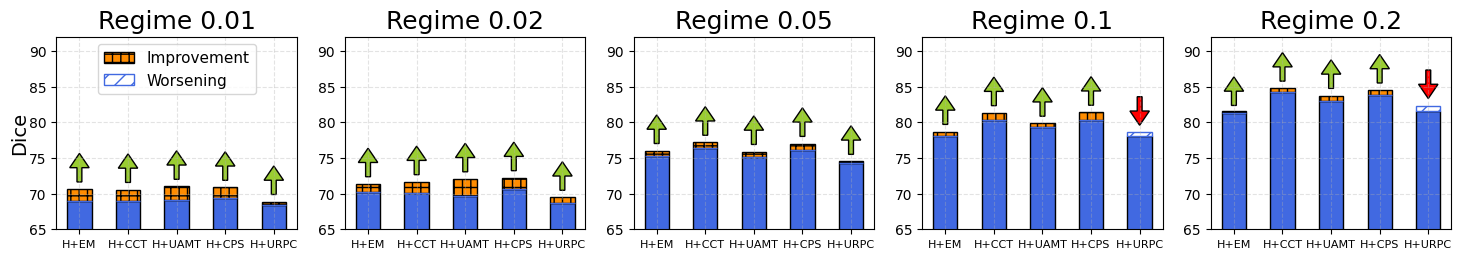

In [176]:
width=0.5

x_labels = ['H+EM', 'H+CCT', 'H+UAMT', 'H+CPS', 'H+URPC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(18, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=0)
    axes[0][j].xaxis.set_tick_params(labelsize=8)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    #axes[0][j].set_ylabel("Dice", fontsize=14, labelpad=-5)
    axes[0][j].yaxis.set_tick_params(labelsize=10)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[0][j].set_ylim([65, 92])

axes[0][0].set_ylabel("Dice", fontsize=14, labelpad=0)


############################
# Regime 0.01
values_001 = [68.92, 68.97, 69.12, 69.32, 68.38]
improvements_001 = [(70.64-68.92), (70.57-68.97), (71.01-69.12), (70.87-69.32), (68.88-68.38)]
worsening_001 = [0, 0, 0, 0, 0]

axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=0, y=70.64+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=1, y=70.57+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=2, y=71.01+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=3, y=70.87+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=4, y=68.88+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].legend(ncol=1, fontsize=11, loc='upper center')

############################
# Regime 0.02
values_002 = [70.23, 70.05, 69.71, 70.60, 68.67]
improvements_002 = [(71.37-70.23), (71.66-70.05), (72.06-69.71), (72.22-70.60), (69.47-68.67)]
worsening_002 = [0, 0, 0, 0, 0]

axes[0,1].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=0, y=71.37+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=1, y=71.66+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=2, y=72.06+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=3, y=72.22+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=4, y=69.47+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
values_005 = [75.34, 76.33, 75.14, 76.17, 74.32]
improvements_005 = [(76.03-75.34), (77.19-76.33), (75.90-75.14), (77.03-76.17), (74.51-74.32)]
worsening_005 = [0, 0, 0, 0, 0]

axes[0,2].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=0, y=76.03+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=1, y=77.19+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=2, y=75.90+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=3, y=77.03+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=4, y=74.51+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[0,2].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
values_01 = [78.08, 80.36, 79.31, 80.35, 78.59-(78.59-78.12)]
improvements_01 = [(78.71-78.08), (81.34-80.36), (79.86-79.31), (81.40-80.35), 0]
worsening_01 = [0, 0, 0, 0, (78.59-78.12)]

axes[0,3].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=0, y=78.71+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=1, y=81.34+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=2, y=79.86+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=3, y=81.40+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=4, y=78.59+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.4, head_length=2)
#axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
values_02 = [81.37, 84.22, 83.03, 83.90, 82.34-(82.34-81.61)]
improvements_02 = [(81.37-81.20), (84.78-84.22), (83.76-83.03), (84.52-83.90), 0]
worsening_02 = [0, 0, 0, 0, (82.34-81.61)]

axes[0,4].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=0, y=81.37+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=1, y=84.78+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=2, y=83.76+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=3, y=84.52+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=4, y=82.34+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.4, head_length=2)
#axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')


#plt.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.1)
plt.savefig("./figures/glas_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h3>PH2 Dataset</h3>

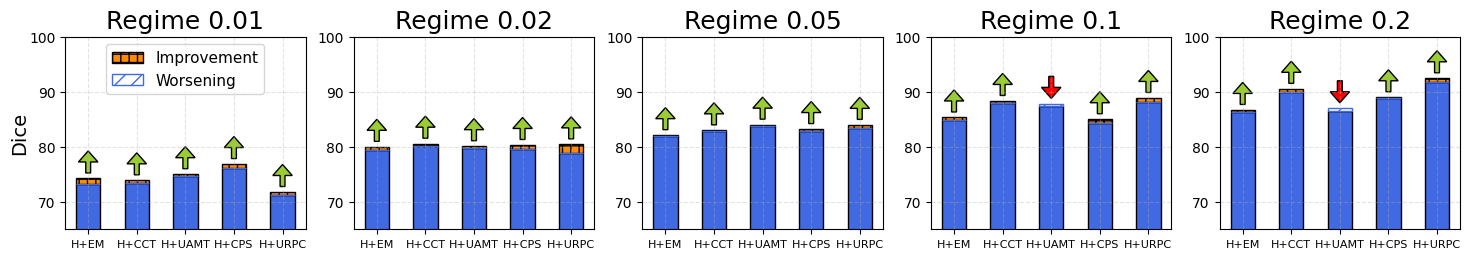

In [192]:
width=0.5

x_labels = ['H+EM', 'H+CCT', 'H+UAMT', 'H+CPS', 'H+URPC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(18, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=0)
    axes[0][j].xaxis.set_tick_params(labelsize=8)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    #axes[0][j].set_ylabel("Dice", fontsize=14, labelpad=-5)
    axes[0][j].yaxis.set_tick_params(labelsize=10)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[0][j].set_ylim([65, 100])

axes[0][0].set_ylabel("Dice", fontsize=14, labelpad=0)


############################
# Regime 0.01
values_001 = [73.24, 73.42, 74.72, 76.07, 71.23]
improvements_001 = [(74.24-73.24), (73.90-73.42), (75.02-74.72), (76.86-76.07), (71.78-71.23)]
worsening_001 = [0, 0, 0, 0, 0]

axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=0, y=74.24+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=1, y=73.90+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=2, y=75.02+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=3, y=76.86+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=4, y=71.78+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].legend(ncol=1, fontsize=11, loc='upper center')

############################
# Regime 0.02
values_002 = [79.34, 80.13, 79.76, 79.64, 78.88]
improvements_002 = [(79.99-79.34), (80.56-80.13), (80.11-79.76), (80.33-79.64), (80.44-78.88)]
worsening_002 = [0, 0, 0, 0, 0]

axes[0,1].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=0, y=79.99+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=1, y=80.56+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=2, y=80.11+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=3, y=80.33+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=4, y=80.44+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
values_005 = [81.89, 82.78, 83.75, 82.86, 83.41]
improvements_005 = [(82.11-81.89), (82.99-82.78), (84.02-83.75), (83.22-82.86), (83.98-83.41)]
worsening_005 = [0, 0, 0, 0, 0]

axes[0,2].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=0, y=82.11+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=1, y=82.99+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=2, y=84.02+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=3, y=83.22+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=4, y=83.98+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[0,2].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
values_01 = [84.94, 87.93, 87.80-(87.80-87.37), 84.33, 88.06]
improvements_01 = [(85.33-84.94), (88.33-87.93), 0, (85.01-84.33), (88.88-88.06)]
worsening_01 = [0, 0, (87.80-87.37), 0, 0]

axes[0,3].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=0, y=85.33+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=1, y=88.33+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=2, y=87.80+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=3, y=85.01+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=4, y=88.88+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
values_02 = [86.30, 89.95, 87.00-(87.00-86.49), 88.95, 91.73]
improvements_02 = [(86.70-86.30), (90.54-89.95), 0, (89-88.95), (92.45-91.73)]
worsening_02 = [0, 0, (87.00-86.49), 0, 0]

axes[0,4].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=0, y=86.70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=1, y=90.54+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=2, y=87.00+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=3, y=89+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=4, y=92.45+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')


#plt.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.1)
plt.savefig("./figures/ph2_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h3>HMEPS Dataset</h3>

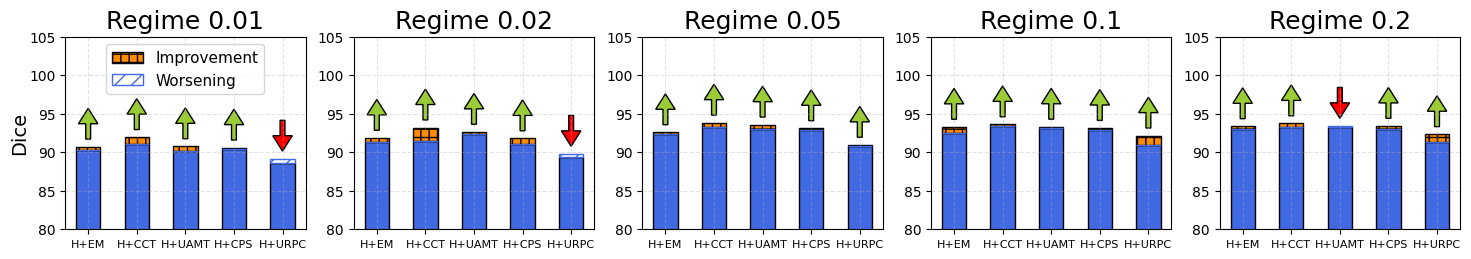

In [185]:
width=0.5

x_labels = ['H+EM', 'H+CCT', 'H+UAMT', 'H+CPS', 'H+URPC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(18, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=0)
    axes[0][j].xaxis.set_tick_params(labelsize=8)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    #axes[0][j].set_ylabel("Dice", fontsize=14, labelpad=-5)
    axes[0][j].yaxis.set_tick_params(labelsize=10)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[0][j].set_ylim([80, 105])

axes[0][0].set_ylabel("Dice", fontsize=14, labelpad=0)


############################
# Regime 0.01
values_001 = [90.24, 91.09, 90.18, 90.39, 89.15-(89.15-88.60)]
improvements_001 = [(90.71-90.24), (91.95-91.09), (90.76-90.18), (90.59-90.39), 0]
worsening_001 = [0, 0, 0, 0, (89.15-88.60)]

axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=0, y=90.71+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=1, y=91.95+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=2, y=90.76+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=3, y=90.59+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].arrow(x=4, y=89.15+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.4, head_length=2)
axes[0,0].legend(ncol=1, fontsize=11, loc='upper center')

############################
# Regime 0.02
values_002 = [91.35, 91.48, 92.42, 91.07, 89.78-(89.78-89.45)]
improvements_002 = [(91.86-91.35), (93.20-91.48), (92.64-92.42), (91.79-91.07), 0]
worsening_002 = [0, 0, 0, 0, (89.78-89.45)]

axes[0,1].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=0, y=91.86+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=1, y=93.20+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=2, y=92.64+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=3, y=91.79+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,1].arrow(x=4, y=89.78+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.4, head_length=2)
#axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
values_005 = [92.31, 93.25, 93.03, 92.89, 90.85]
improvements_005 = [(92.58-92.31), (93.83-93.25), (93.57-93.03), (93.10-92.89), (90.95-90.85)]
worsening_005 = [0, 0, 0, 0, 0]

axes[0,2].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=0, y=92.58+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=1, y=93.83+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=2, y=93.57+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=3, y=93.10+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,2].arrow(x=4, y=90.95+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[0,2].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
values_01 = [92.56, 93.45, 93.14, 92.83, 90.96]
improvements_01 = [(93.29-92.56), (93.61-93.45), (93.30-93.14), (93.14-92.83), (92.15-90.96)]
worsening_01 = [0, 0, 0, 0, 0]

axes[0,3].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=0, y=93.29+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=1, y=93.61+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=2, y=93.30+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=3, y=93.14+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,3].arrow(x=4, y=92.15+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
values_02 = [93.04, 93.30, 93.42-(93.42-93.32), 93.04, 91.30]
improvements_02 = [(93.36-93.04), (93.74-93.30), 0, (93.41-93.04), (92.33-91.30)]
worsening_02 = [0, 0, (93.42-93.32), 0, 0]

axes[0,4].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=0, y=93.36+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=1, y=93.74+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=2, y=93.42+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=3, y=93.41+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
axes[0,4].arrow(x=4, y=92.33+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.4, head_length=2)
#axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')


#plt.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.1)
plt.savefig("./figures/hmeps_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()